# WildFire ML Project - Model Interpretability Notebook

## Import modules

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Import Dataset

In [59]:
# import dataset
source_data_path = "modeling_data.csv"
dataset = pd.read_csv(source_data_path)
# get x and y
x_indic = dataset[["lat","lon","month","sequence"]]

x = dataset[['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness', 'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m', 'climate_rain', 'human_density', 'light_frequency',"burned_area_mom","burned_area_yoy","lat","month"]]
y = dataset["burned_area"]
# convert to numpy
x_indic = np.array(x_indic)
x = np.array(x)
y = np.array(y).reshape(-1, 1)
print(x.shape, y.shape)

(107433, 14) (107433, 1)


## Data Preparation

In [60]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
x_stand = scaler_X.fit_transform(x)
y_stand = scaler_y.fit_transform(y)

In [61]:
split_ratio = 0.8
train_x = x_stand[0:int(split_ratio*len(x_stand)),:]
train_y = y_stand[0:int(split_ratio*len(y_stand)),:]
test_x = x_stand[int(split_ratio*len(x_stand)):x_stand.shape[0],:]
test_y = y_stand[int(split_ratio*len(y_stand)):y_stand.shape[0],:]

In [62]:
train_x = torch.tensor(train_x).float()
train_y = torch.tensor(train_y).float()
test_x = torch.tensor(test_x).float()
test_y = torch.tensor(test_y).float()

In [63]:
X_test = test_x[0:100]
X_train = train_x[0:100]

## Pre-trained Model Load

In [64]:
# Define the neural network
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.layer1 = nn.Linear(train_x.shape[1], train_x.shape[1]*2)
        self.layer2 = nn.Linear(train_x.shape[1]*2, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 4)
        self.layer5 = nn.Linear(4, 1)
        self.activation1 = nn.Tanh()
        self.activation2 = nn.Tanh()
        self.activation3 = nn.Tanh()
        self.activation4 = nn.Tanh()
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.activation3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.activation4(x)
        x = self.dropout(x)
        x = self.layer5(x)

        return x

In [65]:
net = network()
net

network(
  (layer1): Linear(in_features=14, out_features=28, bias=True)
  (layer2): Linear(in_features=28, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=4, bias=True)
  (layer5): Linear(in_features=4, out_features=1, bias=True)
  (activation1): Tanh()
  (activation2): Tanh()
  (activation3): Tanh()
  (activation4): Tanh()
  (dropout): Dropout(p=0.15, inplace=False)
)

In [66]:
model_param_path = "WildFire Prediction.pth"
state_dict = torch.load(model_param_path)
net.load_state_dict(state_dict)

<All keys matched successfully>

## Interpret model - Attribution

In [67]:
ig = IntegratedGradients(net)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(net)
gs = GradientShap(net)
fa = FeatureAblation(net)

In [68]:
ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

F:\Softwares\Anaconda\envs\lawrence\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
F:\Softwares\Anaconda\envs\lawrence\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


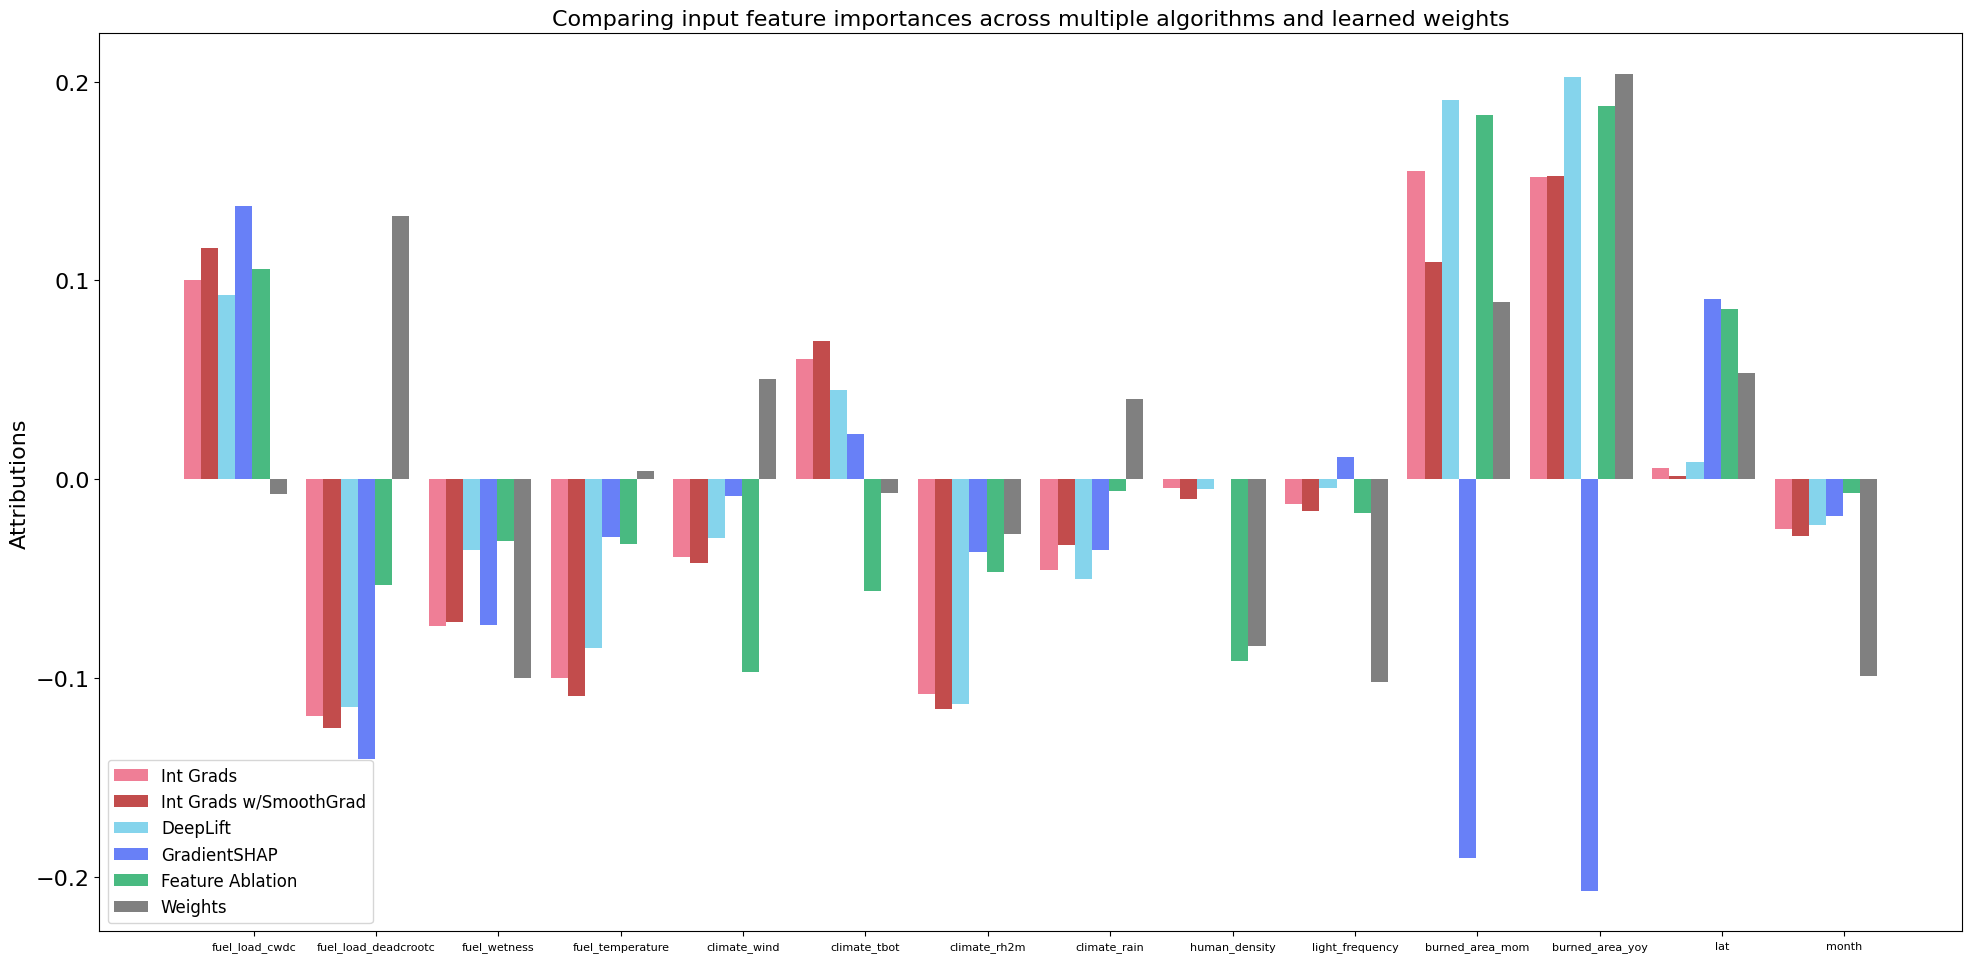

In [69]:
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = ['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness', 'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m', 'climate_rain', 'human_density', 'light_frequency',"burned_area_mom","burned_area_yoy","lat","month"]

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = net.layer1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels, fontsize = 8)

plt.legend(legends, loc=3)
plt.show()

## Attributing to the layers and comparing with model weights

In [70]:
# Compute the attributions of the output with respect to the inputs of the fourth linear layer
lc = LayerConductance(net, net.layer5)

# shape: test_examples x size_hidden
lc_attr_test = lc.attribute(X_test, n_steps=100, attribute_to_layer_input=True)

# weights from forth linear layer
# shape: size_hidden4 x size_hidden3
lin4_weight = net.layer5.weight

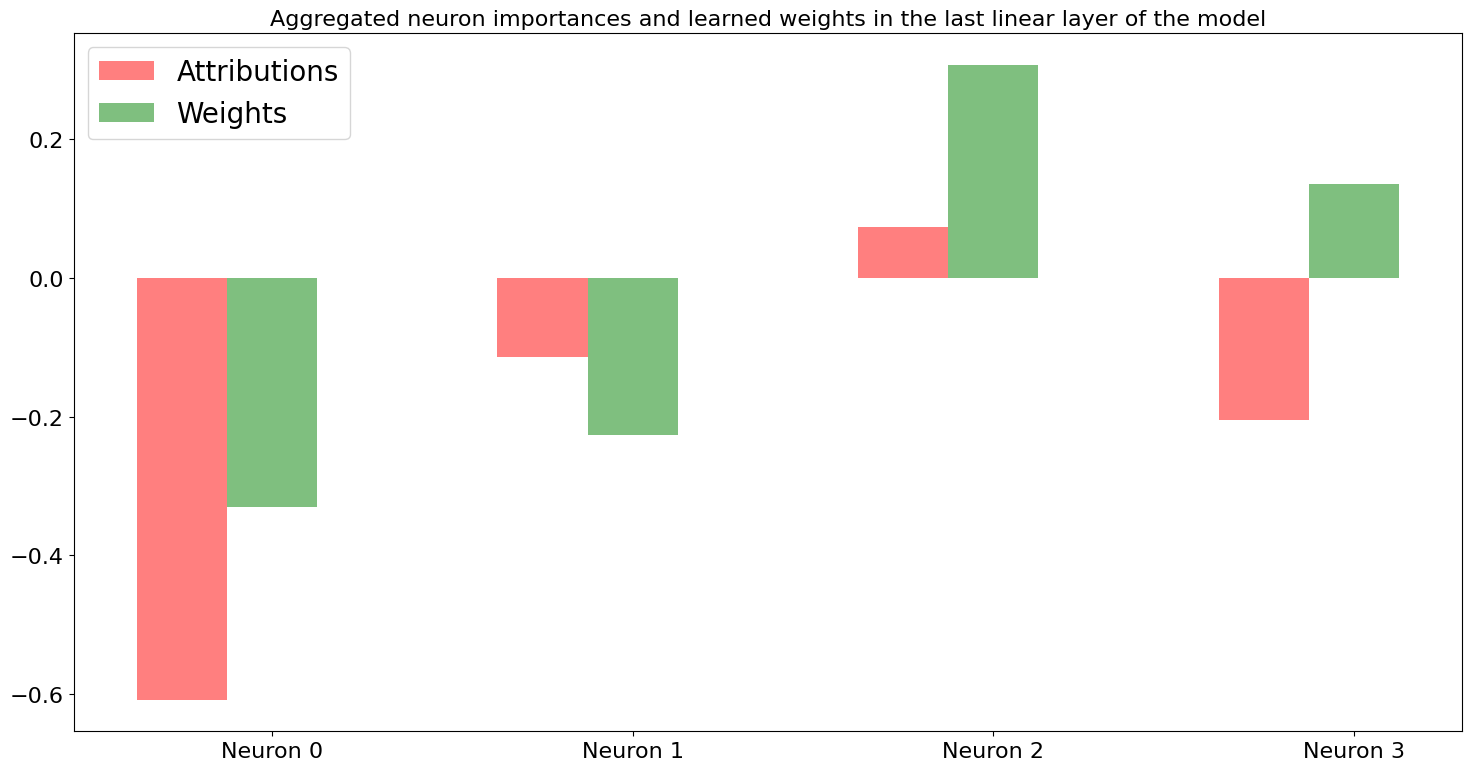

In [71]:
plt.figure(figsize=(15, 8))

x_axis_data = np.arange(lc_attr_test.shape[1])

y_axis_lc_attr_test = lc_attr_test.mean(0).detach().numpy()
y_axis_lc_attr_test = y_axis_lc_attr_test / np.linalg.norm(y_axis_lc_attr_test, ord=1)

y_axis_lin4_weight = lin4_weight[0].detach().numpy()
y_axis_lin4_weight = y_axis_lin4_weight / np.linalg.norm(y_axis_lin4_weight, ord=1)

width = 0.25
legends = ['Attributions','Weights']
x_axis_labels = [ 'Neuron {}'.format(i) for i in range(len(y_axis_lin4_weight))]

ax = plt.subplot()
ax.set_title('Aggregated neuron importances and learned weights in the last linear layer of the model')

ax.bar(x_axis_data + width, y_axis_lc_attr_test, width, align='center', alpha=0.5, color='red')
ax.bar(x_axis_data + 2 * width, y_axis_lin4_weight, width, align='center', alpha=0.5, color='green')
plt.legend(legends, loc=2, prop={'size': 20})
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_labels)

plt.show()